In [1]:
#General Imports
import pandas as pd
import seaborn as sns
from math import ceil
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.feature_selection import f_classif
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import random as rnd
from time import perf_counter as time
import numpy as np
from sklearn.impute import SimpleImputer
from preprocessing_utils import drop_features_, fill_nan_values

In [2]:
dataset_fpath = '../data/BTS1_BTS2_fields_preserved.zip'
nidd_dataset = pd.read_csv(dataset_fpath, compression = 'zip', low_memory=False)

#Attack Type for Multi-Class Classification or Label for Binary Classification
TARGET = 'Label'
DROPPED_TARGET = "Label" if TARGET == "Attack Type" else "Attack Type"

useless_features = ['Attack Tool', DROPPED_TARGET, 'Dport', 'Sport', 'SrcAddr', 'DstAddr',"Unnamed: 0"]
nidd_dataset = nidd_dataset.drop(useless_features, axis=1)
print(f"Original shape of data: {nidd_dataset.shape}")

Original shape of data: (1215890, 106)


In [3]:
features_dropped = {"Nan columns": [], "Zero columns": [], "Constant columns": [], "General columns": useless_features}
preprocessing_d = {"Time <Dropping features based on a threshold `bad` values>": 0.,
                   "Filling NaNs": 0.,
                   "Time <Encoding categorical features>": 0.,
                   "Time <Feature selection>": 0.}



nidd_dataset_cleaned, drop_time = drop_features_(nidd_dataset,[0.95, 0.95], features_dropped)
preprocessing_d["Time <Dropping features based on a threshold `bad` values>"] = drop_time

nidd_dataset_cleaned, fill_time = fill_nan_values(nidd_dataset_cleaned, method = "mean")
preprocessing_d["Filling NaNs"] = fill_time

numeric_cols = nidd_dataset_cleaned.select_dtypes(include='number').columns
categorical_cols = nidd_dataset_cleaned.select_dtypes(include='object').columns

t0 = time()
# Encoding categorical columns
label_encoder = LabelEncoder()
for column in categorical_cols:
    nidd_dataset_cleaned[column] = label_encoder.fit_transform(nidd_dataset_cleaned[column])

t1 = time()
preprocessing_d["Time <Encoding categorical features>"] = t1 - t0


After dropping NaN columns: (1215890, 70)
After dropping NaN & Zero columns: (1215890, 55)
After dropping NaN & Zero & Constant columns: (1215890, 51)


In [5]:

feature_extraction_model = RandomForestClassifier(random_state= rnd.seed(42))
feature_extraction_model.fit(nidd_dataset_cleaned.iloc[:,:-1], nidd_dataset_cleaned[TARGET])

print(f"Feature importance: {feature_extraction_model.feature_importances_}")


Feature importance: [9.31395800e-02 4.00023265e-02 3.84801406e-02 4.11294149e-02
 1.84008235e-01 1.10485364e-03 1.86329086e-03 9.19557528e-02
 2.55396575e-03 3.72272222e-03 3.03244892e-03 1.03512347e-03
 1.19034027e-02 7.59805671e-04 1.23525239e-04 1.30843717e-06
 9.09990336e-02 6.16568412e-03 6.20504770e-02 7.26304106e-03
 2.15173534e-03 1.81129616e-04 5.68277740e-03 3.32067318e-03
 2.81688290e-03 7.98099938e-04 1.33784172e-02 1.39491833e-02
 2.94357883e-03 9.89219061e-02 5.86881245e-02 1.32346762e-03
 1.99366891e-03 1.63415412e-03 1.35917301e-03 1.68635970e-02
 8.58245318e-03 6.17884804e-03 3.67039972e-03 5.82771340e-04
 7.61980994e-03 1.68429275e-02 1.56096678e-02 2.88248109e-03
 1.93011570e-03 3.78186310e-06 1.18679952e-02 9.51781848e-03
 6.66888836e-03 7.41340194e-04]


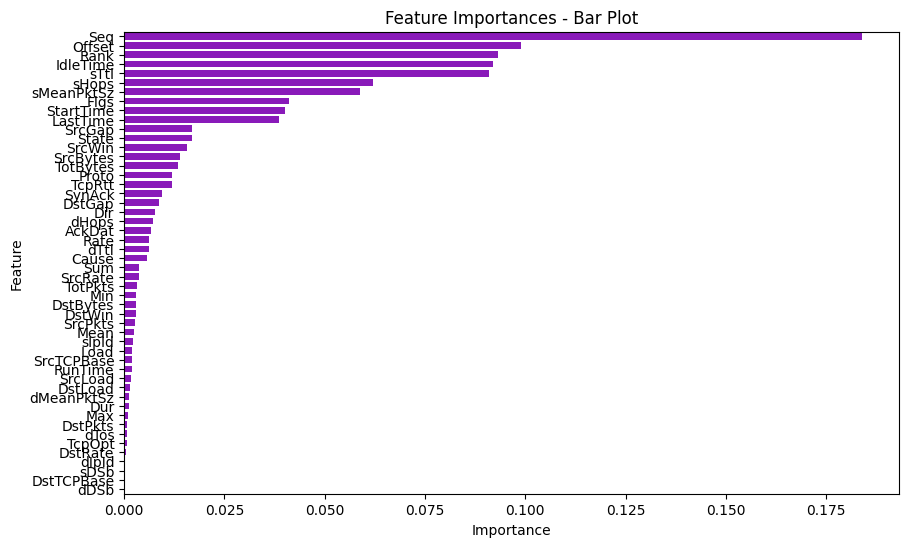

In [6]:
feature_importances_ = pd.DataFrame({'Feature': nidd_dataset_cleaned.iloc[:,:-1].columns, 
                                    'Importance': feature_extraction_model.feature_importances_})

# print(f"Feature importance: {feature_importances_}")
# Bar Plot
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', 
            data=feature_importances_.sort_values(by='Importance', ascending=False),
            width = 1.2, gap = 0.4,
            color = "darkviolet")
plt.title('Feature Importances - Bar Plot')
plt.show()



### Applying Z-normalization to the selected features, training a RandomForest classifier

In [7]:

top_10_features_cols = feature_importances_.sort_values(by='Importance', ascending=False).head(10)['Feature'].values
print(top_10_features_cols)
target = nidd_dataset_cleaned[TARGET]
features = nidd_dataset[top_10_features_cols]
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.3, random_state=rnd.seed(42)) 

numeric_features = list(set(numeric_cols) & set(top_10_features_cols))
categorical_features = list(set(categorical_cols) & set(top_10_features_cols))

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')), 
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
        
    ])

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

pipeline.fit(X_train, y_train)

predictions = pipeline.predict(X_test)



['Seq' 'Offset' 'Rank' 'IdleTime' 'sTtl' 'sHops' 'sMeanPktSz' 'Flgs'
 'StartTime' 'LastTime']


### Plotting Confusion Matrix and classification report

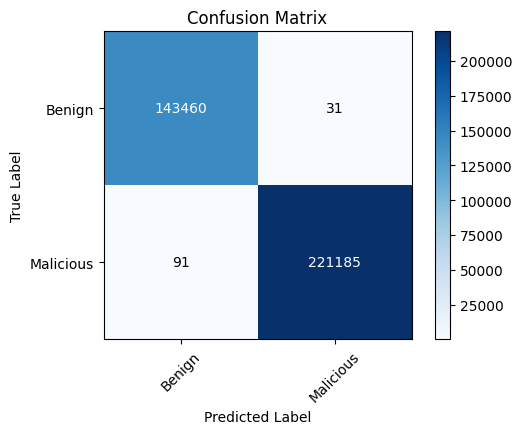

Classification Report:
               precision    recall  f1-score   support

      Benign   0.999366  0.999784  0.999575    143491
   Malicious   0.999860  0.999589  0.999724    221276

    accuracy                       0.999666    364767
   macro avg   0.999613  0.999686  0.999650    364767
weighted avg   0.999666  0.999666  0.999666    364767

Time <Dropping features based on a threshold `bad` values>: 2.4852 seconds
Filling NaNs: 2.2656 seconds
Time <Encoding categorical features>: 1.6425 seconds
Time <Feature selection>: 0.0000 seconds


In [8]:
conf_matrix = confusion_matrix(y_test, predictions)

target_categories = set(nidd_dataset[TARGET])

plt.figure(figsize=(6, 4))
plt.imshow(conf_matrix, cmap=plt.cm.Blues, interpolation='nearest')
plt.title('Confusion Matrix')
plt.colorbar()
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(ticks=np.arange(len(target_categories)), labels=target_categories, rotation=45)
plt.yticks(ticks=np.arange(len(target_categories)), labels=target_categories)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(j, i, format(conf_matrix[i, j], 'd'), ha="center", va="center", color="white" if conf_matrix[i, j] > conf_matrix.max() / 2 else "black")

plt.show()

class_report = classification_report(y_test, predictions, target_names=target_categories , digits=6)
print("Classification Report:\n", class_report)
for key, time in preprocessing_d.items():
    print(f"{key}: {time:.4f} seconds")


In [10]:
import joblib 
from pprint import pprint as pp
import pickle

parameters = pipeline.named_steps['classifier']
print(type(parameters))
# pickle.dump(top_10_features_cols, open('top_10_features_cols.pkl', 'wb'))
joblib.dump(parameters, '../models/RandomForest.pkl')
# pickle.dump(label_encoder, open('label_encoderBinary.pkl', 'wb'))


<class 'sklearn.ensemble._forest.RandomForestClassifier'>


['../models/RandomForest.joblib']